<a href="https://colab.research.google.com/github/PHMark/ML-Personal-Projects/blob/master/e-commerce-recommender-system/E_commerce_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Amazon Ladies Apparel Recommendations </h1>



In [117]:
import requests
import os
from io import BytesIO

from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from wordcloud import WordCloud

In [14]:
# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

% matplotlib inline

In [ ]:
CURRENT_DIR = os.path.abspath(os.curdir)
DATA_DIR = os.path.join(CURRENT_DIR, "drive/My Drive/ML Projects/E-commerce Recommender System/data")
FILE_DIR = os.path.join(DATA_DIR, "2020-08-28-ladies-apparel-tops.json")

In [ ]:
df = pd.read_json(FILE_DIR)

In [15]:
print("Total Number of Data Points: {}\nTotal Number of Features: {}".format(*df.shape))

Total Number of Data Points: 183138
Total Number of Features: 19


In [17]:
print(df.columns)

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')


Because of limited computational resource, and also to iterate on things much faster, we will be using only 6 features namely:

1. **asin** - Amazon standard identification number.

2. **brand** - Brand to which the product belongs to.

3. **color** Color information of apparel, it can contain many colors as a value *ex: red and black stripes*.

4. **product_type_name** - Type of the apperal, *ex: SHIRT/TSHIRT*.

5. **medium_image_url** - URL of the image.

6. **title** - title of the product.

7. **formatted_price** - price of the product.


Since I will use NLP techniques,
these features are relevant for my current use case. Also, intuitively, these metadata gives so much information to describe a product in an e-commerce shop.


In [24]:
df = df[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [25]:
df.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


# 1.) Feature Analysis

The amazon dataset contains 183138 rows, i.e., womens tops, and 19 features. 

**We will analyse the dataset to identify:**

1. Missing values
2. High Level Statistics of each Feature.
3. Check for duplicated data points / products.

## 1.1 Missing Values

Garbage-In-Garbage-Out.

Checking for missing values is an important part of data analysis. Ideally in machine learning, we want to transform our data to be an edible information for our computer to process.

In [26]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 1]

# print the variable name and the percentage of missing values
for var in vars_with_na:
    print(var, np.round(df[var].isnull().mean(), 3),  ' % missing values')

brand 0.001  % missing values
color 0.645  % missing values
formatted_price 0.845  % missing values


Our dataset contains 3 variables with missing values. We need to account for this in our data preprocessing section.

## 1.2 High Level Statistics

In [93]:
def show_feature_statistics(data: pd.Series, n: int, variable_name: str):
  print("Basic Statistics for the {} variable:".format(variable_name))
  print("="*75)
  print(data.describe())
  print("="*75)
  print("\nUnique Values:")
  print(data.unique())
  print("="*75)

  _frequency = data.value_counts()
  plt.figure(figsize=(10, 6))
  plt.title("Top {} most frequent values in the {} variable".format(n, variable_name))
  plt.xlabel("Category Levels")
  plt.ylabel("Frequency")
  _frequency.head(n).plot(kind='bar', color="orange")
  plt.show()

#### 1.2.1 For product_type_name variable

Basic Statistics for the product_type_name variable:
count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object

Unique Values:
['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECO

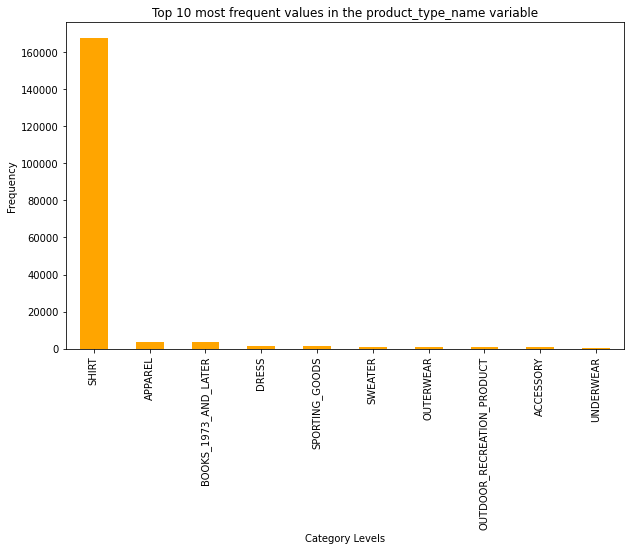

In [94]:
show_feature_statistics(data=df["product_type_name"], n=10, variable_name="product_type_name")

We have a total of 72 unique type of product_type_names, and the most frequent category was "SHIRT".

In [72]:
def plot_wordcloud(data: pd.Series):
  data = data.copy().value_counts()
  data = data.to_dict()
  wordcloud = (WordCloud(background_color='grey', width=640, height=480)
                .generate_from_frequencies(data))
  plt.figure(figsize=(30, 10))
  plt.imshow(wordcloud)
  plt.axis(False)
  plt.show()

#### 1.2.2 For brand variable

Basic Statistics for the brand variable:
count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object

Unique Values:
['FNC7C' 'FIG Clothing' 'Focal18' ... 'Z' "Rain's Pan Jacket"
 'FFLMYUHULIU']


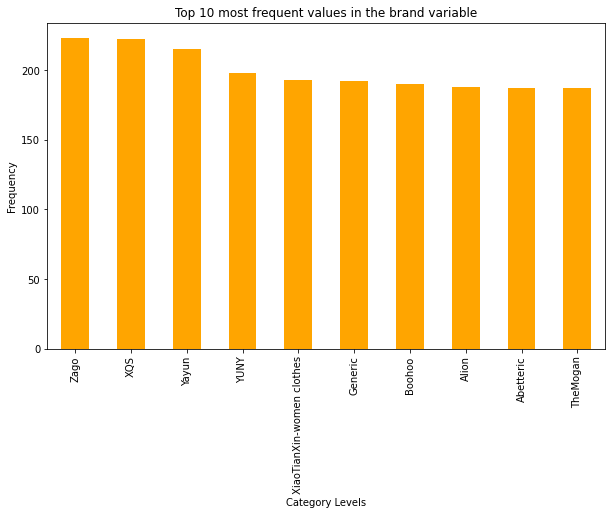

In [95]:
show_feature_statistics(data=df["brand"], n=10, variable_name="brand")

#### 1.2.3 For color variable

Basic Statistics for the color variable:
count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object

Unique Values:
[None 'Onyx Black/ Stone' 'Grape' ... 'Combo C'
 'White, Soft Coral and Charcoal Varigated' 'Monochrome Plaid']


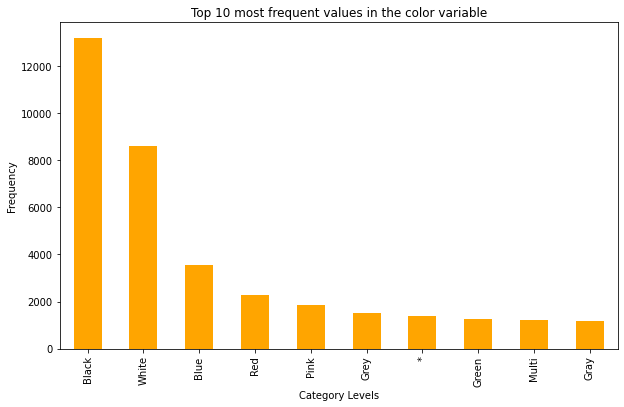

In [96]:
show_feature_statistics(data=df["color"], n=10, variable_name="color")

#### For formatted_price variable

Basic Statistics for the formatted_price variable:
count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object

Unique Values:
[None '$26.26' '$9.99' ... '$16.05' '$88.29' '$28.05']


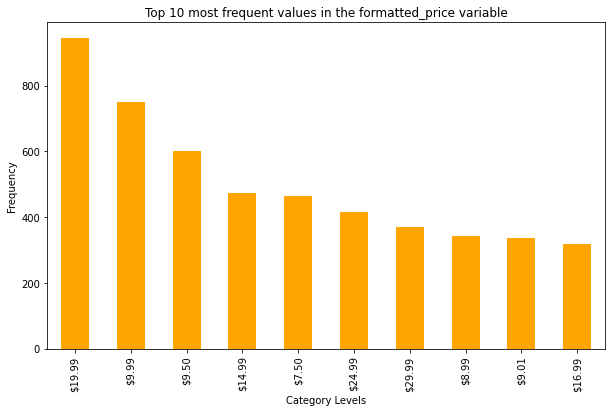

In [97]:
show_feature_statistics(data=df["formatted_price"], n=10, variable_name="formatted_price")

#### For title variable

Basic Statistics for the title variable:
count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object

Unique Values:
['Minions Como Superheroes Ironman Long Sleeve Round Neck T-Shirt For Women'
 'FIG Clothing Womens Izo Tunic' 'FIG Clothing Womens Won Top' ...
 'Wrangler George Strait For Her Long Sleeve Pink Print Western Shirt'
 'Susana Monaco Womens Susana Monoco Sleeveless Smock Top, 6, Pink'
 "SexyBaby Women's Mesh Splive Flounced Sleeve Crew Neck Tops Blouses"]


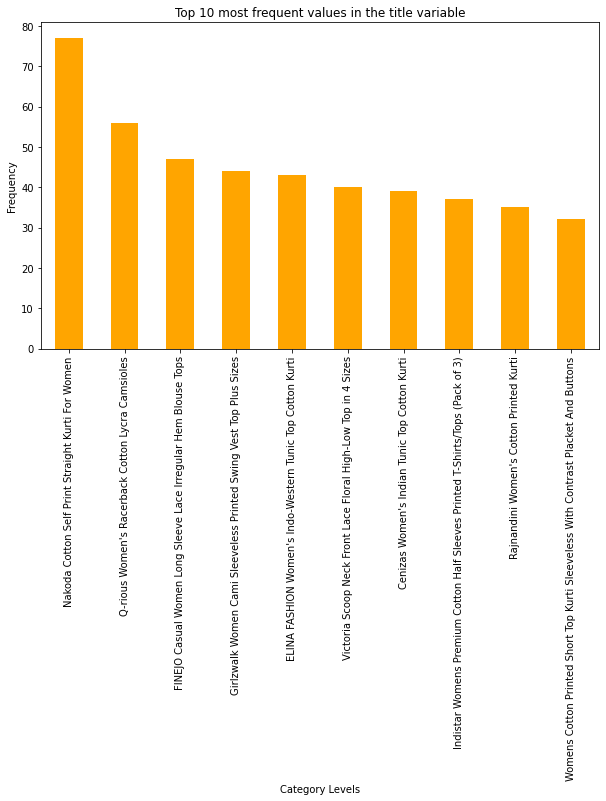

In [99]:
show_feature_statistics(data=df["title"], n=10, variable_name="title")

### 1.3 Check for duplicated data points

In [101]:
print(f"There are {sum(df.duplicated('title'))} products which have the same title.")

There are 7153 products which have the same title.


#### 1.3.1 Visualizing Duplicates

We can visualize duplicate products using the medium_image_url variable.

In [119]:
def get_image(url):
  response = requests.get(url, stream=True)
  img = Image.open(response.raw)
  # img.save('images/28k_images/'+row['asin']+'.jpeg')
  return img

In [137]:
df_sorted = df[df.duplicated('title')].sort_values('title', ascending=True)
df_sorted.iloc[15:26]

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
21138,B072KHBCJQ,3x1,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,3x1 Women's Moxy Wrap Shirt,None
174880,B073XMTJ77,3x1,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,3x1 Women's Moxy Wrap Shirt,None
168881,B074L4PBJB,VONC,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,4 Out Of 3 People Struggle With Math Geometry ...,None
125301,B01G3BYB9U,BRMWs,Black,https://images-na.ssl-images-amazon.com/images...,BOOKS_1973_AND_LATER,45 R.p.m. Club A-ha Hunting High And Low Women...,$10.80
166506,B073ZLB2GL,5 Year Old Birthday Gift Tee Shirt Boy Girl Party,None,https://images-na.ssl-images-amazon.com/images...,ORCA_SHIRT,5 Year Old Birthday Gift Tee Shirt Boy Girl Pa...,None
134345,B01BGAQM40,TeeSher,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,6 inch Vibrator,None
122678,B01CNE2LDO,TeeSher,PU1,https://images-na.ssl-images-amazon.com/images...,SHIRT,6 inch Vibrator,$9.99
45718,B00CJVOI06,Horace Small,Gray,https://images-na.ssl-images-amazon.com/images...,OUTERWEAR,669Gy W S/S Grey Deputy Dlx Shrt,$59.99
63597,B071VYX6ZP,7 Encounter,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,7 Encounter Women's Boat Neck Blouse with Shor...,None
67188,B073X9PV1V,7 Encounter,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,7Encounter Women's Cold-Shoulder Flutter Sleev...,None


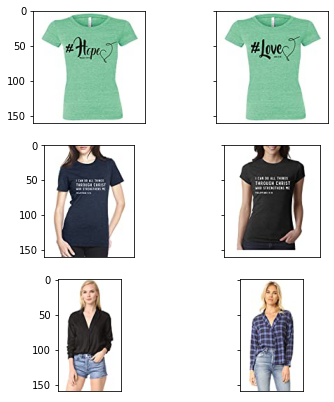

In [160]:
duplicated_asins = ["B072KHBCJQ", "B073XMTJ77", "B074SYFP2W", "B074SRT6LV", "B01LXRS563", "B01M01WPN4"]
image_url_to_visualize = df_sorted.loc[df_sorted["asin"].isin(duplicated_asins), "medium_image_url"].values

fig, axes = plt.subplots(3, 2, figsize=(6, 7), sharey=True)
for ax, url in zip(axes, image_url_to_visualize.reshape((3, 2))):
  img1, img2 = get_image(url[0]), get_image(url[1])
  ax[0].imshow(img1)
  ax[0].set_xticks([])
  ax[1].imshow(img2)
  ax[1].set_xticks([])
plt.show()

In the real world, let's say *Person A is Browsing Product X (color blue)*, it is not a good strategy to recommend Product X (color green) or Product X that does differ in design to Person A.